### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

![alt text](images/4.png)

In [1]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
llm=ChatGroq(model="qwen-2.5-32b")

In [2]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display
from typing import Annotated,List
import operator

class Section(BaseModel):
    name:str=Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections for the report"
    )

planner=llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [ ]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


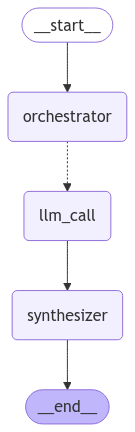

Report Sections: sections=[Section(name='Introduction to Agentic AI RAGs', description='Definition, background, and context of Agentic AI RAGs in the field of artificial intelligence.'), Section(name='Applications of Agentic AI RAGs', description='Real-world use cases and how Agentic AI RAGs are being applied in industries such as healthcare, finance, and customer service.'), Section(name='Technical Overview', description='Technical details and methodologies behind Agentic AI RAGs including the integration of retrieval and generation models.'), Section(name='Benefits of Agentic AI RAGs', description='Positive impacts and advantages of using Agentic AI RAGs in various sectors.'), Section(name='Challenges and Limitations', description='Potential issues and limitations associated with Agentic AI RAGs.'), Section(name='Future Prospects', description='Potential advancements and future directions for Agentic AI RAGs.')]


## Introduction to Agentic AI RAGs

Agentic AI RAGs, or Retrieval-Augmented Generation (RAG) systems, represent a significant advancement in the field of artificial intelligence, particularly in the realm of natural language processing (NLP). These systems combine the strengths of information retrieval (IR) and text generation to create more contextually aware and informative responses. The concept of agentic AI RAGs is rooted in the broader context of AI systems designed to interact with and assist humans in complex, dynamic environments. By integrating retrieval mechanisms, these systems can access a vast repository of information, enhancing their ability to generate responses that are not only syntactically correct but also semantically rich and contextually relevant.

The origin of AI RAGs can be traced back to the evolution of machine learning techniques, where earlier models relied heavily on predefined rules or statistical patterns to generate text. However, as the need for more sophisticated and adaptive AI systems grew, researchers began exploring methods to augment these systems with knowledge from external sources. This led to the development of RAG models that can query a database or an external knowledge base to retrieve relevant information and use it as a basis for generating responses. The term "agentic" in this context implies an active role in seeking out and utilizing information to fulfill tasks or answer queries effectively.

In the broader AI landscape, Agentic AI RAGs stand out for their potential to revolutionize applications such as virtual assistants, customer support systems, and educational tools. They offer a more nuanced approach to interaction, making AI systems more adept at understanding and responding to complex user needs. As technology continues to advance, the role of Agentic AI RAGs is expected to grow, playing a crucial part in enhancing human-AI interaction and facilitating more meaningful and effective communication.

---

## Applications of Agentic AI RAGs

Agentic AI RAGs (Retrieval-Augmented Generation models) have found diverse applications across several industries, leveraging their ability to enhance decision-making processes, automate routine tasks, and provide personalized services. In healthcare, Agentic AI RAGs are used for diagnosing diseases through analysis of patient records and medical literature, assisting in the development of personalized treatment plans, and improving the accuracy of medical imaging interpretations.

In finance, these models are employed for risk assessment, fraud detection, and customer credit scoring, significantly reducing the time and effort required for manual analysis. They enable the processing of vast amounts of financial data, providing real-time insights and predictions that can inform investment decisions and regulatory compliance.

Customer service is another domain where Agentic AI RAGs have made significant inroads. They power advanced chatbots and virtual assistants, capable of engaging in natural language conversations, understanding customer needs, and providing tailored solutions. This not only enhances customer satisfaction but also reduces operational costs by automating routine queries and support tasks.

Overall, Agentic AI RAGs are driving innovation by adapting to specific industry needs, improving efficiency, and delivering more accurate and personalized services.

---

## Technical Overview

Agentic AI RAGs (Retrieval-Augmented Generation) integrate two primary components: retrieval models and generation models. The retrieval model is responsible for sourcing relevant information from a large corpus of documents, while the generation model synthesizes this information into coherent and contextually relevant responses.

### Retrieval Model

The retrieval model within Agentic AI RAGs is designed to efficiently search through a vast database of documents or knowledge bases. This model typically employs techniques such as dense retrieval, where documents are represented as dense vectors in a high-dimensional space, facilitating fast similarity searches. The model uses embeddings generated from transformer architectures, which are fine-tuned for the retrieval task. This allows for precise and context-aware document retrieval based on query inputs.

### Generation Model

The generation model is a sophisticated language model, often a variant of the transformer architecture, which is fine-tuned to produce human-like responses. It leverages the output of the retrieval model by conditioning its generation process on the most relevant retrieved documents. This approach not only enhances the factual correctness of the responses but also improves the overall quality and coherence of the generated text.

### Integration Mechanism

The integration of retrieval and generation models in Agentic AI RAGs is achieved through a unified framework that allows for seamless interaction between the two. During inference, the retrieval model first identifies the most relevant documents to the user's query. These documents are then used as additional context for the generation model, which synthesizes a response that integrates the retrieved information into a coherent output.

This method ensures that the generated responses are not only contextually relevant but also supported by existing knowledge, making the system highly effective in scenarios requiring accurate and detailed information provision.

### Key Features

- **Efficient Retrieval**: Utilizes efficient indexing and dense vector representations for fast and accurate document retrieval.
- **Contextual Generation**: Enhances language generation with contextual data retrieved from the most relevant documents.
- **Fine-Tuning and Adaptability**: The models can be fine-tuned for specific tasks or domains, increasing their effectiveness and relevance.

This technical overview highlights the innovative integration of retrieval and generation models in Agentic AI RAGs, enabling more accurate, contextually relevant, and informative responses.

---

### Benefits of Agentic AI RAGs

Agentic AI Retrieval-Augmented Generation (RAG) systems bring significant positive impacts and advantages across various sectors. These systems combine the strengths of retrieval mechanisms and generative models to provide tailored responses and information, enhancing efficiency, accuracy, and personalization. In healthcare, Agentic AI RAGs can assist in diagnosing diseases by analyzing patient data and providing relevant medical literature, resulting in more accurate diagnoses and personalized treatment plans. In finance, these systems can offer real-time market analysis and investment advice, enhancing decision-making processes. In customer service, Agentic AI RAGs can understand customer queries more accurately and provide relevant, context-aware responses, improving customer satisfaction. Additionally, in education, they can offer personalized learning paths and resources, catering to individual student needs and enhancing the learning experience. Overall, the implementation of Agentic AI RAGs can lead to significant advancements in productivity, service quality, and user experience across industries.

---

### Challenges and Limitations

Agentic AI RAGs (Retriever-Augmented Generation models) face several potential issues and limitations that can affect their performance and reliability. These include challenges in data quality and availability, the complexity of integrating retrieval and generation processes, and ethical considerations around bias and privacy.

**Data Quality and Availability:**
The effectiveness of Agentic AI RAGs largely depends on the quality and comprehensiveness of the data they are trained on. Incomplete or inaccurate data can lead to flawed outputs, while the lack of access to up-to-date information can result in outdated responses, especially in rapidly changing fields such as technology and medicine.

**Integration Complexity:**
Integrating retrieval mechanisms with generation processes can be technically challenging. Ensuring that the retrieval system efficiently finds relevant content and that the generation model accurately uses this content to produce coherent and contextually appropriate responses requires fine-tuning and robust testing. Additionally, there can be issues with the consistency of the generated text, particularly when the model has to switch between different retrieval sources or when the retrieved information is of varying quality.

**Ethical Considerations:**
Ethical concerns, such as bias and privacy, are critical issues that must be addressed in the development and deployment of Agentic AI RAGs. Biases in the training data can lead to biased outputs from the model, which can have significant societal impacts. Privacy concerns arise when sensitive or personal information is included in the data sets used for training or when the model is used to generate content that could expose such information.

Addressing these challenges requires not only technical innovation but also a comprehensive ethical framework to guide the development and use of Agentic AI RAGs.

---

## Future Prospects

The future of Agentic AI RAGs (Retrieval-Augmented Generation) holds significant potential for advancements and new directions. One key area is the integration of more sophisticated learning mechanisms that allow these systems to adapt and learn continuously from their interactions, improving their performance over time without the need for extensive retraining.

Another promising direction is the enhancement of multi-agent collaboration, where multiple AI RAGs can work together to solve more complex problems, sharing information and learning from each other in real-time. This could lead to a more flexible and scalable AI framework capable of handling a broader spectrum of tasks and challenges.

Additionally, there is a growing interest in ethical AI and ensuring that Agentic AI RAGs are not only intelligent but also fair and unbiased. Future research will likely focus on developing methodologies to detect and mitigate biases within these systems, ensuring they are reliable and trustworthy.

The integration of these advancements will not only enhance the capabilities of Agentic AI RAGs but also pave the way for their broader application across various sectors, from healthcare to financial services, making them indispensable tools in the digital age.

In [16]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])